In [142]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
%matplotlib inline

In [143]:
# na_filter = False -> None nao é um missing value
energia21 = pd.read_csv('./train_datasets/energia_202109-202112.csv', encoding='latin-1', na_filter=False)
energia22 = pd.read_csv('./train_datasets/energia_202201-202212.csv', encoding='latin-1',na_filter=False)

meteo21 = pd.read_csv('./train_datasets/meteo_202109-202112.csv', encoding='latin-1')
meteo22 = pd.read_csv('./train_datasets/meteo_202201-202212.csv', encoding='latin-1')



##### Merge datasets

In [144]:
energiaDatasets = pd.concat([energia22, energia21])
energiaDatasets.to_csv("combinedEnergia.csv", index=False)

In [145]:
energiaDatasets.head()

,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2022-01-01,0,0.0,0.486,0.0,None
1,2022-01-01,1,0.0,0.429,0.0,None
2,2022-01-01,2,0.0,0.463,0.0,None
3,2022-01-01,3,0.0,0.545,0.0,None
4,2022-01-01,4,0.0,0.439,0.0,None


In [146]:
energiaDatasets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11016 entries, 0 to 2255
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Data                     11016 non-null  object 
 1   Hora                     11016 non-null  int64  
 2   Normal (kWh)             11016 non-null  float64
 3   Horário Económico (kWh)  11016 non-null  float64
 4   Autoconsumo (kWh)        11016 non-null  float64
 5   Injeção na rede (kWh)    11016 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 602.4+ KB


<Axes: >

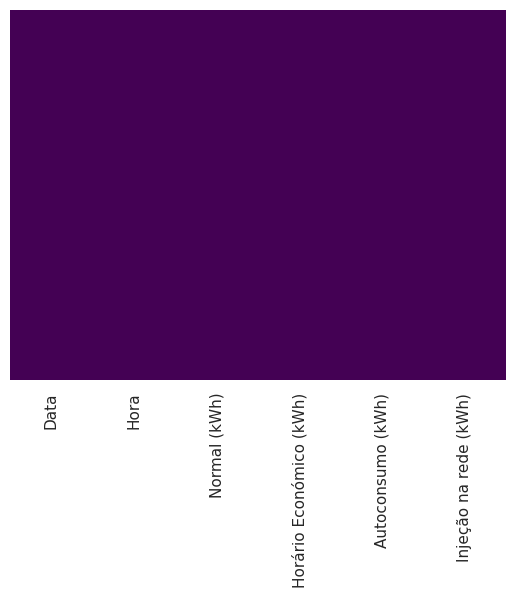

In [147]:
sns.heatmap(energiaDatasets.isnull(), yticklabels = False, cbar=False, cmap='viridis')

In [148]:
print(energiaDatasets['Injeção na rede (kWh)'].value_counts())

Injeção na rede (kWh)
None         7777
High         1103
Medium       1098
Very High     606
Low           432
Name: count, dtype: int64


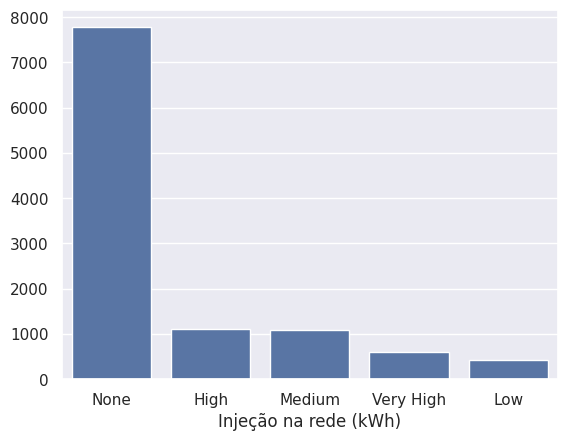

In [149]:
inj_count = energiaDatasets['Injeção na rede (kWh)'].value_counts()
sns.set(style='darkgrid')
sns.barplot(x=inj_count.index, y=inj_count.values)
plt.show()

In [150]:
'''
nova coluna para a inje na rede ter valores
None-3, Low-1, Medium-2, High-0, Very High-4
'''
lb_make = LabelEncoder()
energiaDatasets['Inj_code'] = lb_make.fit_transform(energiaDatasets['Injeção na rede (kWh)'])

energiaDatasets.head()

,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),Inj_code
0,2022-01-01,0,0.0,0.486,0.0,None,3
1,2022-01-01,1,0.0,0.429,0.0,None,3
2,2022-01-01,2,0.0,0.463,0.0,None,3
3,2022-01-01,3,0.0,0.545,0.0,None,3
4,2022-01-01,4,0.0,0.439,0.0,None,3


In [151]:
# Merge the two dataframes
meteoDatasets = pd.concat([meteo21, meteo22])

meteoDatasets.to_csv("combinedMeteo.csv", index=False)

In [152]:
meteoDatasets.isnull().sum()

dt                         0
dt_iso                     0
city_name                  0
temp                       0
feels_like                 0
temp_min                   0
temp_max                   0
pressure                   0
sea_level              11688
grnd_level             11688
humidity                   0
wind_speed                 0
rain_1h                 9253
clouds_all                 0
weather_description        0
dtype: int64

<Axes: >

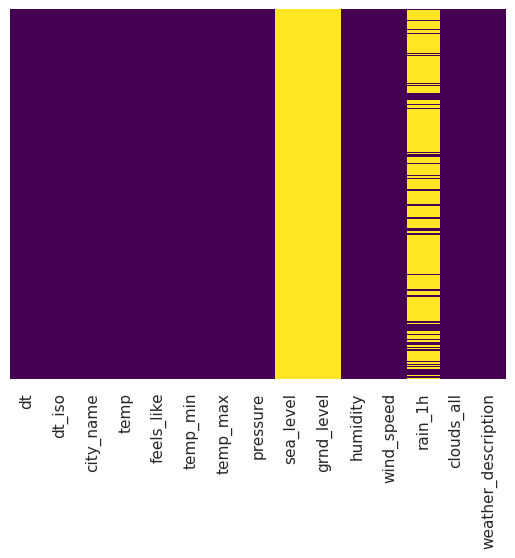

In [153]:
sns.heatmap(meteoDatasets.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [154]:
meteoDatasets.nunique()

dt                     11688
dt_iso                 11688
city_name                  1
temp                    2423
feels_like              2702
temp_min                 488
temp_max                 550
pressure                  41
sea_level                  0
grnd_level                 0
humidity                  82
wind_speed               771
rain_1h                  371
clouds_all               101
weather_description        8
dtype: int64

In [155]:
meteoDatasets.drop(['sea_level','grnd_level','city_name'], axis=1,inplace=True)

In [156]:
meteoDatasets['rain_1h'].describe()

count    2435.000000
mean        0.884760
std         1.073453
min         0.100000
25%         0.210000
50%         0.450000
75%         1.070000
max         7.450000
Name: rain_1h, dtype: float64

In [157]:
meteoDatasets['rain_1h'].fillna(0.895706, inplace = True)

<Axes: >

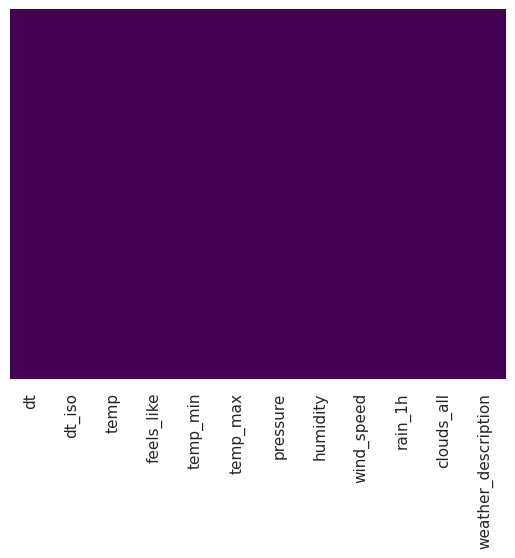

In [158]:
sns.heatmap(meteoDatasets.isnull(),yticklabels=False,cbar=False,cmap='viridis')

##### Merge datasets 

In [159]:
meteoDatasets['dt_iso'] = meteoDatasets['dt_iso'].str.strip()
meteoDatasets['Data'] = meteoDatasets['dt_iso'].str.split().str[0]
meteoDatasets['Hora'] = meteoDatasets['dt_iso'].str.split().str[1].str[:2].astype('int64') # 2 primeiros digitos

meteoDatasets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11688 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dt                   11688 non-null  int64  
 1   dt_iso               11688 non-null  object 
 2   temp                 11688 non-null  float64
 3   feels_like           11688 non-null  float64
 4   temp_min             11688 non-null  float64
 5   temp_max             11688 non-null  float64
 6   pressure             11688 non-null  int64  
 7   humidity             11688 non-null  int64  
 8   wind_speed           11688 non-null  float64
 9   rain_1h              11688 non-null  float64
 10  clouds_all           11688 non-null  int64  
 11  weather_description  11688 non-null  object 
 12  Data                 11688 non-null  object 
 13  Hora                 11688 non-null  int64  
dtypes: float64(6), int64(5), object(3)
memory usage: 1.3+ MB


In [160]:
merged_df = pd.merge(meteoDatasets, energiaDatasets , on=['Data', 'Hora'], how='inner')

merged_df.to_csv('merged_df.csv', index=False)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   dt                       11016 non-null  int64  
 1   dt_iso                   11016 non-null  object 
 2   temp                     11016 non-null  float64
 3   feels_like               11016 non-null  float64
 4   temp_min                 11016 non-null  float64
 5   temp_max                 11016 non-null  float64
 6   pressure                 11016 non-null  int64  
 7   humidity                 11016 non-null  int64  
 8   wind_speed               11016 non-null  float64
 9   rain_1h                  11016 non-null  float64
 10  clouds_all               11016 non-null  int64  
 11  weather_description      11016 non-null  object 
 12  Data                     11016 non-null  object 
 13  Hora                     11016 non-null  int64  
 14  Normal (kWh)          

In [161]:
merged_df.nunique()

dt                         11016
dt_iso                     11016
temp                        2382
feels_like                  2670
temp_min                     481
temp_max                     545
pressure                      41
humidity                      82
wind_speed                   771
rain_1h                      368
clouds_all                   101
weather_description            8
Data                         459
Hora                          24
Normal (kWh)                1282
Horário Económico (kWh)      851
Autoconsumo (kWh)            752
Injeção na rede (kWh)          5
Inj_code                       5
dtype: int64

In [169]:
merged_df['temp_min'].describe()

count    11016.000000
mean        14.195064
std          4.956014
min         -0.640000
25%         10.720000
50%         14.230000
75%         17.490000
max         36.720000
Name: temp_min, dtype: float64

### outliers

<Axes: ylabel='feels_like'>

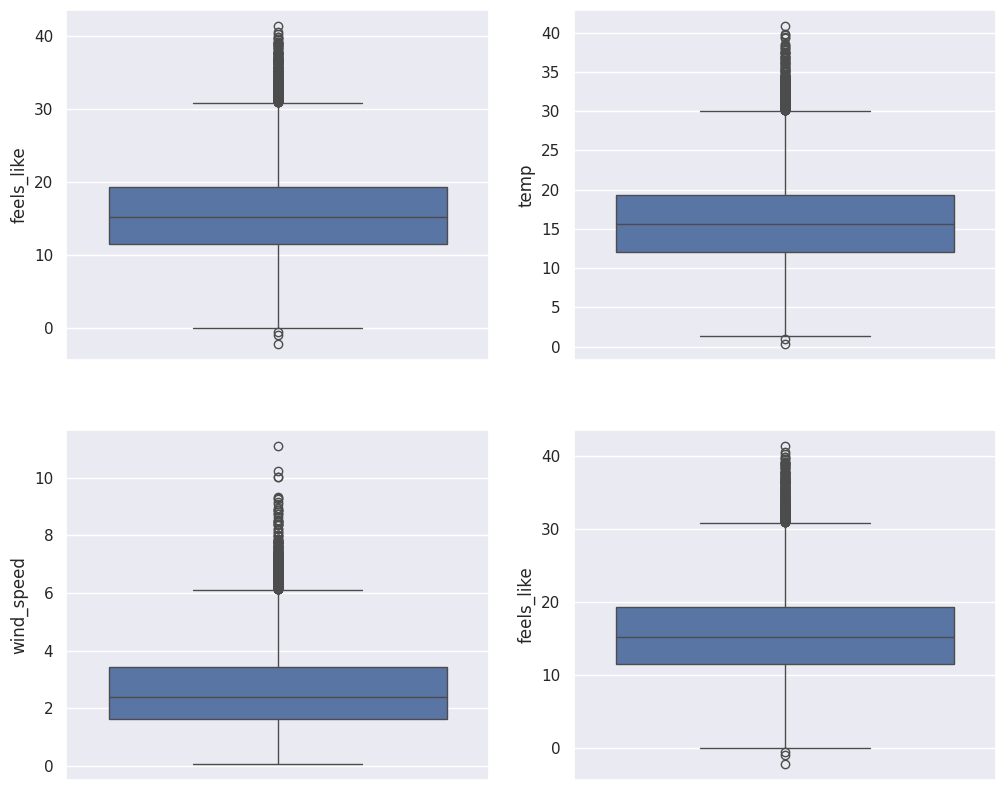

In [166]:
fig, axs = plt.subplots(2,2,figsize=(12,10))
sns.boxplot(y=merged_df['feels_like'], ax=axs[0,0])
sns.boxplot(y=merged_df['temp'], ax=axs[0,1])
sns.boxplot(y=merged_df['wind_speed'], ax=axs[1,0])
sns.boxplot(y=merged_df['feels_like'], ax=axs[1,1])

### explore the dataset

<Axes: >

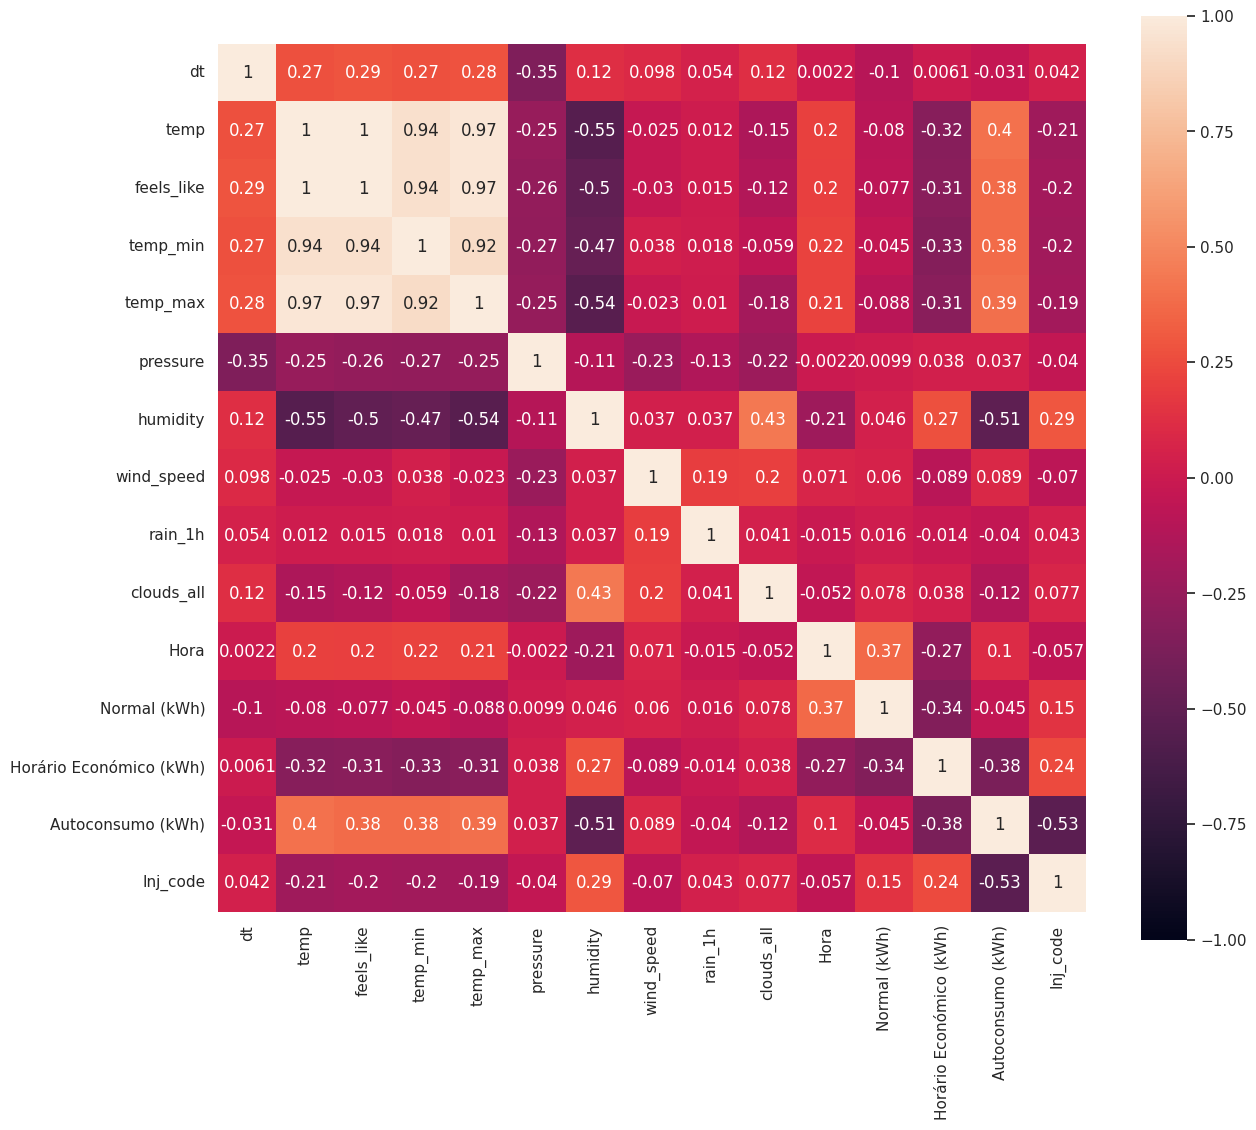

In [121]:
''''
Correlation

'''
corr_matrix = merged_df.drop(['Injeção na rede (kWh)','dt_iso','Data', 'weather_description'], axis=1).corr(numeric_only = True)
f,ax = plt.subplots(figsize=(14,12))
sns.heatmap(corr_matrix,vmin=-1,vmax=1, square=True,annot=True)


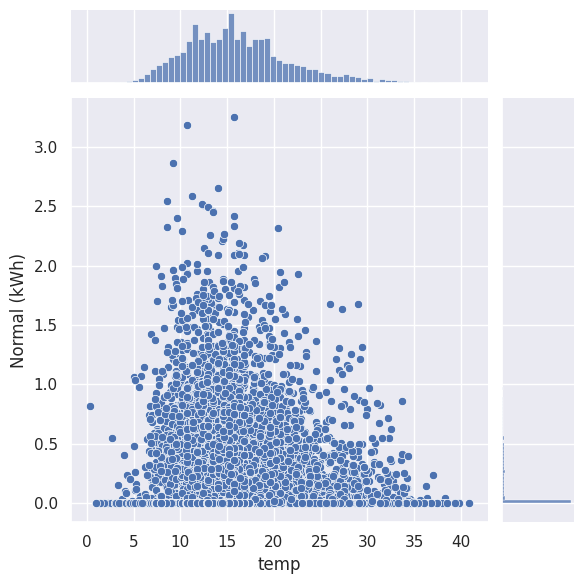

In [122]:
sns.jointplot(merged_df, x='temp', y='Normal (kWh)')

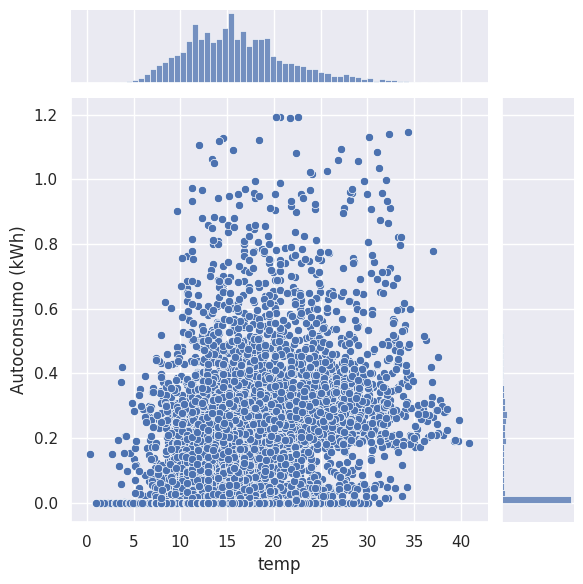

In [123]:
sns.jointplot(merged_df, x='temp', y='Autoconsumo (kWh)')

--> higher temperatures tend to have lower autoconsumption

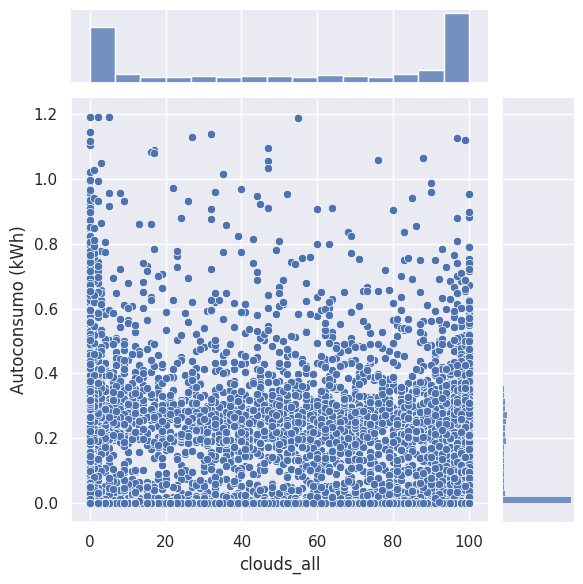

In [124]:
sns.jointplot(merged_df, x='clouds_all', y='Autoconsumo (kWh)')

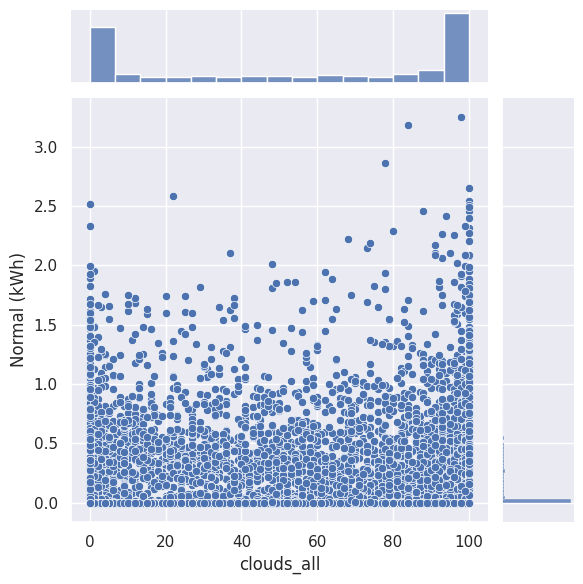

In [125]:
sns.jointplot(merged_df, x='clouds_all', y='Normal (kWh)')

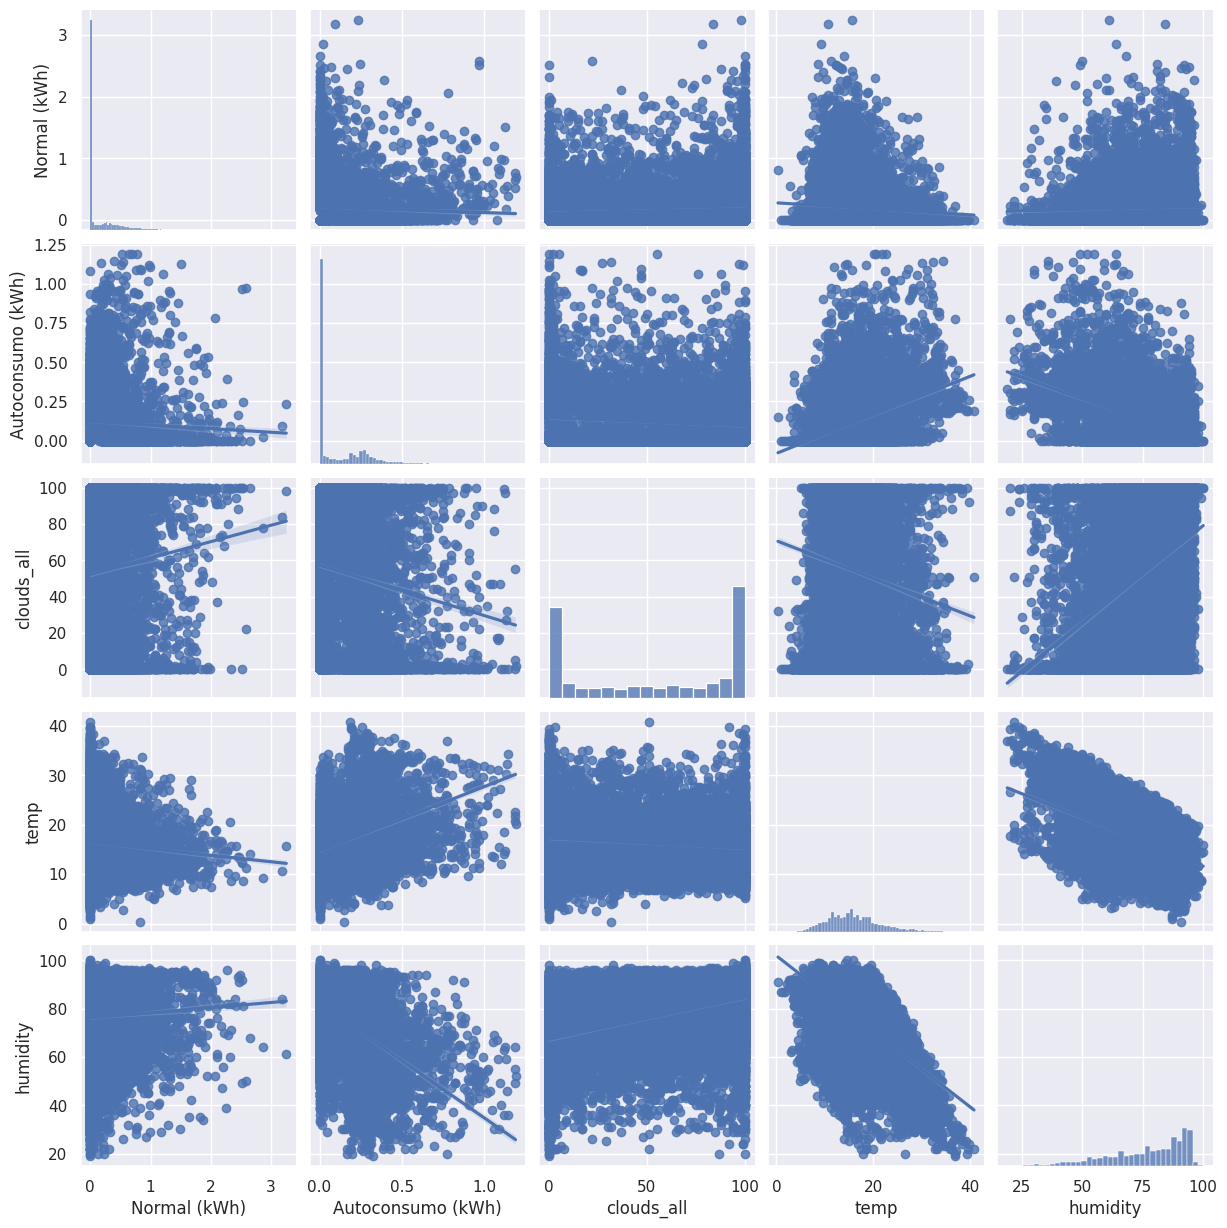

In [126]:
cols = ['Normal (kWh)', 'Autoconsumo (kWh)', 'clouds_all', 'temp', 'humidity']
sns.pairplot(merged_df[cols], height=2.5, kind='reg')